In [ ]:
!pip install lazypredict

In [2]:
import numpy as np
import pandas as pd
import sys
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn
import lazypredict
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a437tgyi because the default path (/home/determined_keller/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
df_train = pd.read_csv('../DATA/train_airbnb_berlin.xls')

# without label
#df_validation = pd.read_csv('./test_airbnb_berlin.xls') 

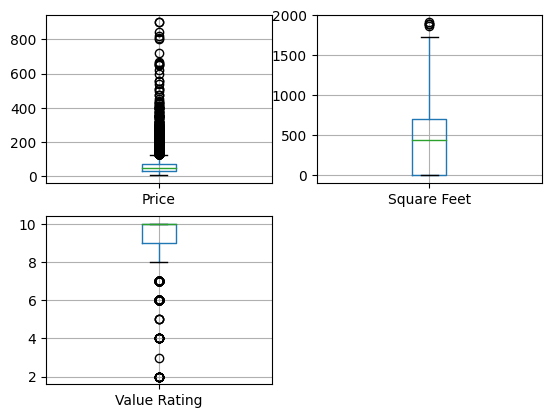

In [4]:
plt.subplot(221)
df_train.boxplot(column='Price')

plt.subplot(222)
df_train.boxplot(column='Square Feet')

plt.subplot(223)
df_train.boxplot(column='Value Rating')

plt.show()

In [5]:
def percentage_of_nans(df: pd.DataFrame) -> list:
    nan_percentage = pd.DataFrame(columns=['Feature Name', 'Percentage of NaNs'])
    for idx, feature in enumerate(df.columns):
        notnans = df_train[feature].notna().value_counts()
        percentage = 0
        if False in notnans:
            percentage = int(10000*notnans[False]/len(df_train))/100

        nan_percentage.loc[idx] = [feature, percentage]
    return nan_percentage

In [8]:
nan_percentage = percentage_of_nans(df_train)
df = nan_percentage[nan_percentage['Percentage of NaNs'] == 0]
df.sort_values(by=['Percentage of NaNs'], ascending=False)

,Feature Name,Percentage of NaNs
0,Listing ID,0.0
2,Host ID,0.0
36,Instant Bookable,0.0
26,Reviews,0.0
25,Min Nights,0.0
24,Guests Included,0.0
19,Accomodates,0.0
18,Room Type,0.0
17,Property Type,0.0
16,Is Exact Location,0.0


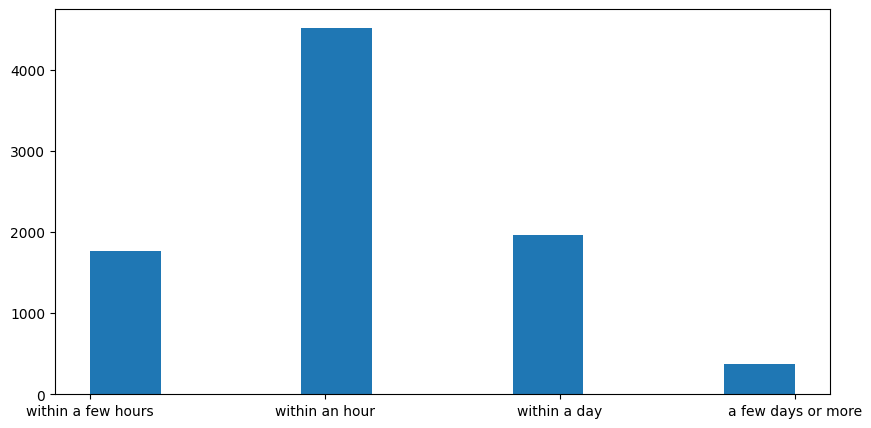

In [7]:
plt.figure(figsize=(10, 5))
plt.hist(df_train['Host Response Time'].dropna())
plt.show()


In [9]:
df = df_train.copy()
df.replace(['f', 't'], [0, 1], inplace=True)
df.replace(["*", 'nan'], [np.NaN, np.NaN], inplace=True)
values = list(df['Host Response Time'].value_counts().keys())
mapping = {
    'within an hour': 3,
    'within a few hours': 2,
    'within a day': 1,
    'a few days or more': 0
}
df['Host Response Time'] = df['Host Response Time'].map(mapping)
numerical_variables = ['Latitude', 'Longitude', 'Accomodates', 'Guests Included', 'Min Nights', 'Reviews']
variables = numerical_variables.copy()
variables.append('Host Response Time')
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(df[variables])


In [56]:
def replace_na(df : pd.DataFrame, numerical_variables : list()):
    df.replace(['f', 't'], [0, 1], inplace=True)
    df.replace(["*"], [np.NaN], inplace=True)
    
    # missing values replaced by mean
    for column in numerical_variables:
        df[column] = pd.to_numeric(df[column],'coerce')
        mean = df[column].mean()
        df[column] = df[column].fillna(mean)

    return df

    
def pre_process(df : pd.DataFrame):

    numerical_variables = ['Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Square Feet', 'Guests Included', 'Min Nights',\
        'Reviews']
    ratings = ['Accuracy Rating', 'Value Rating', 'Checkin Rating', 'Overall Rating', 'Location Rating', 'Communication Rating', 'Cleanliness Rating']
    numerical_variables += ratings

    categorical_variables = ['Room Type', 'Property Type']

    boolean_variables = ['Is Exact Location', 'Instant Bookable', 'Business Travel Ready']

    drop_variables = ['Square Feet']

    selected_columns = numerical_variables + categorical_variables + boolean_variables

    label_in = 'Price' in df.columns
    if label_in:
        selected_columns.append('Price')
    
    
    df = replace_na(df, numerical_variables)

    df = df[selected_columns]
    df.dropna(inplace=True)
    
    # categorcial to dummies
    for cat_var in categorical_variables:
        dummie = pd.get_dummies(df[cat_var])
        df = pd.concat([df, dummie], axis=1)

    #rescale the coordinates ?
    sklearn.preprocessing.minmax_scale(df['Latitude'], feature_range=(-10, 10), copy=False)
    sklearn.preprocessing.minmax_scale(df['Longitude'], feature_range=(-10, 10), copy=False)

    y = df['Price']
    df.drop(["Price", "Room Type", "Property Type"], axis=1, inplace=True)
    
    if(label_in):
        return df, y
    
    return df

In [57]:
X, y = pre_process(df_train)

#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=42)

KeyError: 'Host Response Time'

In [129]:
# import sklearn.linear_model
# import sklearn.svm
# import sklearn.neural_network
# import sklearn.ensemble


# #model = sklearn.linear_model.Ridge()
# #model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,3))
# #model = sklearn.svm.SVR(kernel='poly')
# model = sklearn.ensemble.RandomForestRegressor()

# model.fit(X_train, y_train)

# y_train_predict = model.predict(X_train)
# y_test_predict = model.predict(X_test)


import xgboost as xgb
param = {'max_depth':5, 'eta':1, 'objective':'reg:squarederror' }
num_round = 2

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(param, dtrain, num_round)
y_train_predict = bst.predict(dtrain)
y_test_predict = bst.predict(dtest)

#from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
# reg.fit(X_train, X_test, y_train, y_test)


# evaluation
train_mse = sklearn.metrics.mean_squared_error(y_train, y_train_predict)
train_r2 = sklearn.metrics.r2_score(y_train, y_train_predict)
print("Train MSE: "+str(train_mse))
print("Train R2: "+str(train_r2))

test_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predict)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_predict)
print("Test MSE: "+str(test_mse))
print("Test R2: "+str(test_r2))




Train MSE: 1287.806422766963
Train R2: 0.44093457095961264
Test MSE: 1435.987956161085
Test R2: 0.40227173859973275


In [101]:
y_test - y_test_predict

13964    13.432511
6105    -13.281156
9001     -5.677313
12335   -31.224319
11237     4.764753
           ...    
1956    -17.298526
10375    -4.126278
3972    -11.257448
5302    -16.109106
96      -32.127213
Name: Price, Length: 3122, dtype: float64